# 高斯混合模型(Gaussian Mixture Models)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy import random
from tqdm.notebook import tqdm

# MNIST Dataset

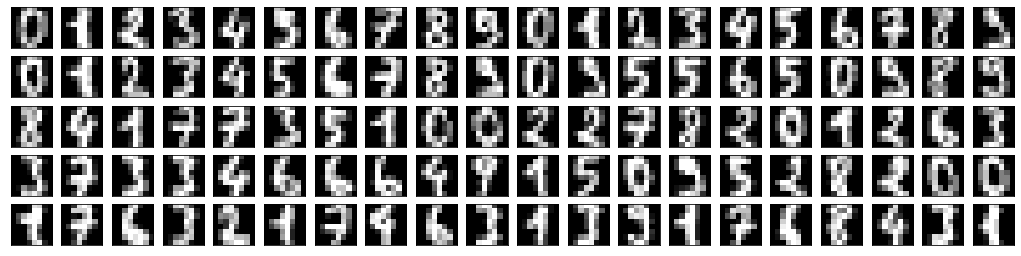

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X=digits.data/16
y=digits.target
plt.rcParams["figure.figsize"] = (18,18)
plt.gray() 
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show() 

# t-SNE

In [3]:
from scipy.spatial.distance import cdist
def Nearest_Neighbor(X,n_neighbors):
    distance = cdist(X,X,"euclidean")
    neighbors_index=np.argsort(distance,axis=1)[:,1:n_neighbors+1]
    neighbors=np.sort(distance,axis=1)[:,1:n_neighbors+1]
    return neighbors,neighbors_index
import math
def _binary_search_perplexity(neighbors,neighbors_index,perplexity,verbose):
    EPSILON_DBL = 1e-8
    PERPLEXITY_TOLERANCE = 1e-5
    n_steps = 100
    n_samples,n_neighbors  = neighbors.shape
    using_neighbors = n_neighbors < n_samples
    beta_sum = 0.0
    desired_entropy = math.log(perplexity)
    P = np.zeros((n_samples, n_samples), dtype=np.float64)
    for i in tqdm(range(n_samples)):
        beta_min = -np.Inf
        beta_max = np.Inf
        beta = 1.0
        for l in range(n_steps):
            sum_Pi = 0.0
            P[i,neighbors_index[i]]=np.exp(-neighbors[i]* beta)
            sum_Pi=np.sum(P[i,:])
            if sum_Pi == 0.0:
                sum_Pi = EPSILON_DBL
            P[i,:]/=sum_Pi
            sum_disti_Pi=np.sum(P[i,neighbors_index[i]]*neighbors[i])
            entropy = math.log(sum_Pi) + beta * sum_disti_Pi
            entropy_diff = entropy - desired_entropy
            if math.fabs(entropy_diff) <= PERPLEXITY_TOLERANCE:
                break
            if entropy_diff > 0.0:
                beta_min = beta
                if beta_max == np.Inf:
                    beta *= 2.0
                else:
                    beta = (beta + beta_max) / 2.0
            else:
                beta_max = beta
                if beta_min == -np.Inf:
                    beta /= 2.0
                else:
                    beta = (beta + beta_min) / 2.0
        beta_sum += beta
    return P
def PCA(X,n_components,N):
    X_center=X-np.mean(X,axis=0)
    W,D,V=np.linalg.svd(X_center.T)
    X_embedded=np.dot(X_center,W[:,:n_components])
    return X_embedded
from scipy.spatial.distance import pdist
def _kl_divergence(X_embedded,P,N,n_components):
    MACHINE_EPSILON_ARRAY=np.ones(N)*np.finfo(np.double).eps
    dist=(cdist(X_embedded,X_embedded,"euclidean")**2+1)**-1
    Q = np.maximum(dist/np.sum(dist.ravel()),MACHINE_EPSILON_ARRAY)
    PQd = (P-Q)*dist
    grad=np.zeros(X_embedded.shape)
    for i in range(N):
        grad[i]=4*np.dot(PQd[i],X_embedded[i]-X_embedded)
    return grad
def gradient_descent(Y,P,gradient,max_iter,learning_rate,momentum):
    for t in tqdm(range(max_iter)):
        if(t<1):
            pre_pre_Y=Y.copy()
            Y=pre_pre_Y-learning_rate*gradient
            pre_Y=Y.copy()
        else:
            Y=pre_Y-learning_rate*gradient+momentum*(pre_Y-pre_pre_Y)
            pre_pre_Y=pre_Y.copy()
            pre_Y=Y.copy()
        gradient=_kl_divergence(Y,P,N,n_components)
    return Y
N,M=X.shape
n_neighbors=30
n_components=2
neighbors,neighbors_index=Nearest_Neighbor(X,n_neighbors)
early_exaggeration=12.0
MACHINE_EPSILON=np.finfo(np.double).eps
neighbors = neighbors.reshape(N, -1)
neighbors = neighbors.astype(np.float32, copy=False)
conditional_P = _binary_search_perplexity(neighbors,neighbors_index,30, 0)
indptr=np.linspace(0,N*n_neighbors,N+1).astype(int)
P = conditional_P + conditional_P.T
P/=(2*N)
X_embedded=PCA(X,n_components,N)
grad=_kl_divergence(X_embedded,P,N,n_components)
Y=X_embedded.copy()
gradient=grad.copy()
max_iter=750
learning_rate=200
momentum=0.2
X_sub=gradient_descent(Y,P*early_exaggeration,gradient,max_iter,learning_rate,momentum)

# k-mean (initialize)

In [4]:
k=10
d=2
N=X.shape[0]
X_emb=X_sub.copy()
init_index=np.zeros(k)
k_mean=np.zeros((k,d))
for i in range(k):
    k_mean[i]=np.mean(X_emb[y==i],axis=0)
max_iter=100
for t in range(max_iter):
    dist=sp.spatial.distance.cdist(X_emb,k_mean,metric='euclidean')
    cluster_index=np.argmin(dist,axis=1)
    for i in range(k):
        BOOL=(cluster_index==i)
        k_mean[i]=np.mean(X_emb[BOOL],axis=0)
print(k_mean)

[[-0.3116179  -6.15116405]
 [-0.5181387   1.6181603 ]
 [ 2.42447593  1.91901611]
 [ 1.65106903  0.10733067]
 [-2.23269261  1.91501257]
 [-0.23900392 -0.66208265]
 [-2.31167841 -2.55344481]
 [-0.53893996  2.98178897]
 [ 0.56721679  1.09964458]
 [ 1.21542755 -0.56525115]]


# GMM

In [5]:
mean=k_mean.copy()
var=np.zeros((k,d,d))
for i in range(k):
    var[i]=np.diag(np.ones(d))
alpha=np.ones(k)/k
gaussian_tmp=np.zeros((k,N))
max_iter=100
for itr in tqdm(range(max_iter)):
    for i in range(k):
        const=1/np.sqrt(((2*np.pi)**d)*np.linalg.det(var[i]))
        var_inv=np.linalg.inv(var[i])
        for j in range(N):
            gaussian_tmp[i,j]=const*np.exp(-0.5*np.dot(np.dot(X_emb[j]-mean[i],var_inv),X_emb[j]-mean[i]))
    beta=alpha[:,None]*gaussian_tmp
    beta/=np.sum(beta,axis=0)
    sum_beta=np.sum(beta,axis=1)
    for i in range(k):
        mean[i]=np.sum(beta[i,:,None]*X_emb,axis=0)/sum_beta[i]
    for i in range(k):
        var[i]=np.dot((beta[i,:,None]*(X_emb-mean[i])).T,(X_emb-mean[i]))/(sum_beta[i]*d)
    alpha=sum_beta/N
print(alpha)
print(var[0])


[0.09905398 0.16949675 0.10626801 0.18035446 0.10694566 0.10028305
 0.10072343 0.10729567 0.0206847  0.0088943 ]
[[ 0.05358957 -0.00084825]
 [-0.00084825  0.04330102]]


# Plot

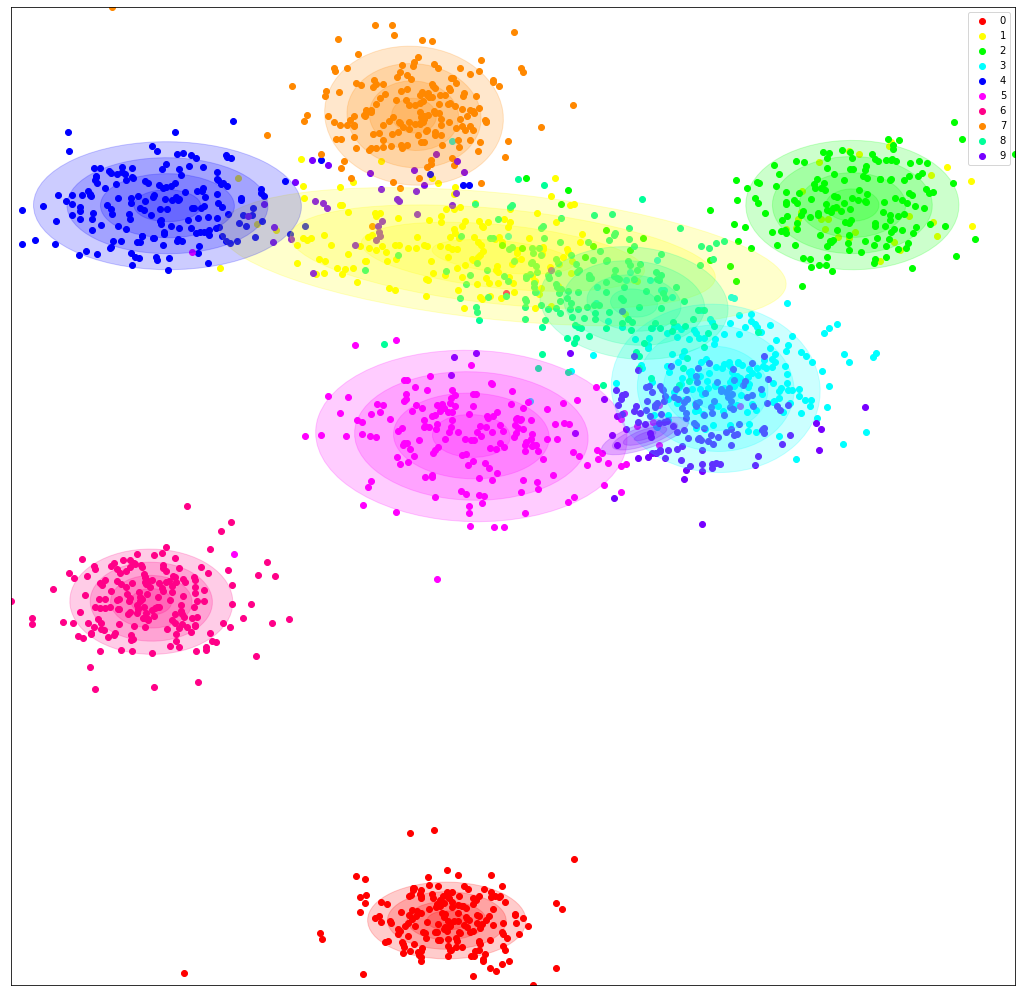

In [6]:
from matplotlib.patches import Ellipse
import math
color=["#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF",
       "#FF00FF","#FF0088","#FF8800","#00FF99","#7700FF"]
plt.rcParams["figure.figsize"] = (18,18)
fig = plt.figure()
ax = fig.add_subplot(111,xlim=(min(X_emb[:,0]),max(X_emb[:,0])),ylim=(min(X_emb[:,1]),max(X_emb[:,1])))
for i in range(0,10):
    BOOL=(y==i)
    plt.scatter(X_emb[BOOL,0],X_emb[BOOL,1],c=color[i],label=i)
    for j in range(1,5):
        ellipse = Ellipse((mean[i,0],mean[i,1]),5*j*var[i,0,0],5*j*var[i,1,1],
                          angle=math.atan(var[i,0,1]/var[i,0,0])*180/np.pi,color=color[i],alpha=0.2)
        ax.add_artist(ellipse)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=10)
plt.show()